# Comparing change in EFP and the resolution

$\Delta$ EFP vs resolution

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns

import functions.eddy_feedback as ef

In [2]:
data_dir = '/home/links/ct715/data_storage/PAMIP/processed_monthly/efp_pd_non-regridded'

ds = {}
# Loop through all .nc files in the directory
for filename in sorted(os.listdir(data_dir)):
    if filename.endswith('.nc'):
        parts = filename.split('_')
        model = parts[0]  # Model name

        key = f'{model}'
        file_path = os.path.join(data_dir, filename)

        # Load dataset and assign model and realization as attributes
        ds[key] = xr.open_dataset(file_path).assign_attrs(model=model)

In [3]:
model_res = {}
for key, value in ds.items():
    
    # calculate each model res
    resolution = abs(ds[key].lat[0] - ds[key].lat[1])
    
    model_res[key] = resolution.values.item()


In [4]:
# Convert to DataFrame
df_res = pd.DataFrame([
    {"Model": model, "Calculated Resolution": values} 
    for model, values in model_res.items()
                    ])#.set_index('Model')
df_res = df_res[df_res['Model'] != 'ECHAM6.3']
df_res = df_res[df_res['Model'] != 'E3SMv1']
df_res = df_res[df_res['Model'] != 'OpenIFS-511']
df_res = df_res.reset_index(drop=True)
df_res

,Model,Calculated Resolution
0,CESM1-WACCM-SC,1.894737
1,CESM2,0.942408
2,CNRM-CM6-1,1.389030
3,CanESM5,2.767272
4,EC-EARTH3,0.695870
5,FGOALS-f3-L,1.000000
6,HadGEM3-GC31-LL,1.250000
7,HadGEM3-GC31-MM,0.555557
8,IPSL-CM6A-LR,1.267609
9,MIROC6,1.389030


In [5]:
# Load the CSV
data_path = '/home/links/ct715/eddy_feedback/reproduce/data/efp'
file_path = os.path.join(data_path, 'previous_comparison_efp.csv')
df_diff = pd.read_csv(file_path)

# Calculate percentage difference: ((Regridded - New) / Regridded) * 100
# Ensure positive percentages and round to 1 decimal place

df_diff['NH_pct_diff'] = (abs(df_diff['Regridded NH EFP'] - df_diff['New NH EFP']) / abs(df_diff['Regridded NH EFP'])) * 100
df_diff['NH_pct_diff'] = df_diff['NH_pct_diff'].round(1)

df_diff['SH_pct_diff'] = (abs(df_diff['Regridded SH EFP'] - df_diff['New SH EFP']) / abs(df_diff['Regridded SH EFP'])) * 100
df_diff['SH_pct_diff'] = df_diff['SH_pct_diff'].round(1)

# Handle potential division by zero (if any regridded values are zero)
df_diff[['NH_pct_diff', 'SH_pct_diff']] = df_diff[['NH_pct_diff', 'SH_pct_diff']].replace([np.inf, -np.inf], np.nan)

# View the updated DataFrame
df_diff = df_diff[df_diff['Model'] != 'OpenIFS-511']
df_diff

,Model,Regridded NH EFP,New NH EFP,Regridded SH EFP,New SH EFP,NH_pct_diff,SH_pct_diff
0,CESM1-WACCM-SC,0.1446,0.1325,0.0308,0.0295,8.4,4.2
1,CESM2,0.4213,0.3782,0.3803,0.3528,10.2,7.2
2,CNRM-CM6-1,0.2819,0.2469,0.2549,0.2145,12.4,15.8
3,CanESM5,0.4516,0.4314,0.4917,0.4715,4.5,4.1
4,EC-EARTH3,0.3538,0.3003,0.3699,0.3194,15.1,13.7
5,FGOALS-f3-L,0.2688,0.2395,0.1548,0.1306,10.9,15.6
6,HadGEM3-GC31-LL,0.3216,0.2780,0.3496,0.3037,13.6,13.1
7,HadGEM3-GC31-MM,0.3807,0.3166,0.3705,0.3071,16.8,17.1
8,IPSL-CM6A-LR,0.3090,0.2762,0.2366,0.2015,10.6,14.8
9,MIROC6,0.2578,0.2216,0.3714,0.3316,14.0,10.7


In [6]:
# Merge the two dataframes 
df = pd.concat([df_diff, df_res['Calculated Resolution']], axis=1)
df

,Model,Regridded NH EFP,New NH EFP,Regridded SH EFP,New SH EFP,NH_pct_diff,SH_pct_diff,Calculated Resolution
0,CESM1-WACCM-SC,0.1446,0.1325,0.0308,0.0295,8.4,4.2,1.894737
1,CESM2,0.4213,0.3782,0.3803,0.3528,10.2,7.2,0.942408
2,CNRM-CM6-1,0.2819,0.2469,0.2549,0.2145,12.4,15.8,1.389030
3,CanESM5,0.4516,0.4314,0.4917,0.4715,4.5,4.1,2.767272
4,EC-EARTH3,0.3538,0.3003,0.3699,0.3194,15.1,13.7,0.695870
5,FGOALS-f3-L,0.2688,0.2395,0.1548,0.1306,10.9,15.6,1.000000
6,HadGEM3-GC31-LL,0.3216,0.2780,0.3496,0.3037,13.6,13.1,1.250000
7,HadGEM3-GC31-MM,0.3807,0.3166,0.3705,0.3071,16.8,17.1,0.555557
8,IPSL-CM6A-LR,0.3090,0.2762,0.2366,0.2015,10.6,14.8,1.267609
9,MIROC6,0.2578,0.2216,0.3714,0.3316,14.0,10.7,1.389030


In [7]:
# correct resolution values
correct_res = {
    'CESM2': 1.25,
    'CanESM5': 2.8,
    'CNRM-CM6-1': 1.0,
    'E3SMv1': 1.0,
    'EC-EARTH3': 1.0,
    'ECHAM6.3': 0.94,
    'FGOALS-f3-L': 1.0,
    'HadGEM3-GC31-MM': 0.55,
    'HadGEM3-GC31-LL': 1.25,
    'IPSL-CM6A-LR': 1.26,
    'MIROC6': 1.4,
    'NorESM2-LM': 1.9,
    'OpenIFS-159': 1.125,
    'OpenIFS-511': 0.352,
    'OpenIFS-1279': 0.14,
    'CESM1-WACCM-SC': 1.9
}

# Convert to DataFrame
res_df = pd.DataFrame([
    {"Model": model, "Resolution": res}
    for model, res in correct_res.items()
])

# Merge on 'Model'
merged_df = df.merge(res_df, on="Model", how="left")
df = merged_df
df

,Model,Regridded NH EFP,New NH EFP,Regridded SH EFP,New SH EFP,NH_pct_diff,SH_pct_diff,Calculated Resolution,Resolution
0,CESM1-WACCM-SC,0.1446,0.1325,0.0308,0.0295,8.4,4.2,1.894737,1.900
1,CESM2,0.4213,0.3782,0.3803,0.3528,10.2,7.2,0.942408,1.250
2,CNRM-CM6-1,0.2819,0.2469,0.2549,0.2145,12.4,15.8,1.389030,1.000
3,CanESM5,0.4516,0.4314,0.4917,0.4715,4.5,4.1,2.767272,2.800
4,EC-EARTH3,0.3538,0.3003,0.3699,0.3194,15.1,13.7,0.695870,1.000
5,FGOALS-f3-L,0.2688,0.2395,0.1548,0.1306,10.9,15.6,1.000000,1.000
6,HadGEM3-GC31-LL,0.3216,0.2780,0.3496,0.3037,13.6,13.1,1.250000,1.250
7,HadGEM3-GC31-MM,0.3807,0.3166,0.3705,0.3071,16.8,17.1,0.555557,0.550
8,IPSL-CM6A-LR,0.3090,0.2762,0.2366,0.2015,10.6,14.8,1.267609,1.260
9,MIROC6,0.2578,0.2216,0.3714,0.3316,14.0,10.7,1.389030,1.400


# Both hemispheres

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def plot_pct_diff_vs_resolution(
    df, 
    x_col='Resolution',
    y1_col='NH_pct_diff',
    y2_col='SH_pct_diff',
    hue_col='Model',
    style_col='Model',
    title='EFP Percentage Difference vs Model Resolution',
    x_label='Latitude Resolution ($^\\circ$)',
    y_label='Percentage Difference (%)',
    y1_title='Northern Hemisphere',
    y2_title='Southern Hemisphere'
):
    """
    Plot NH and SH percentage differences against model resolution with regression and Pearson r.

    Parameters are similar to previous function but adapted for percentage difference plots.
    """
    
    def add_correlation(ax, x, y):
        corr, _ = pearsonr(x, y)
        ax.text(0.7, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
                fontsize=14, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # NH plot
    sns.scatterplot(
        x=df[x_col], 
        y=df[y1_col], 
        hue=df[hue_col], 
        style=df[style_col], 
        ax=axes[0], 
        s=100
    )
    sns.regplot(
        x=df[x_col], 
        y=df[y1_col], 
        scatter=False, 
        ax=axes[0], 
        color="black", 
        ci=None
    )
    axes[0].set_title(y1_title, fontsize=14)
    axes[0].set_xlabel(x_label, fontsize=14)
    axes[0].set_ylabel(y_label, fontsize=14)
    axes[0].set_ylim(0, 20)
    axes[0].tick_params(labelsize=14)
    axes[0].get_legend().remove()
    add_correlation(axes[0], df[x_col], df[y1_col])

    # SH plot
    sns.scatterplot(
        x=df[x_col], 
        y=df[y2_col], 
        hue=df[hue_col], 
        style=df[style_col], 
        ax=axes[1], 
        s=100
    )
    sns.regplot(
        x=df[x_col], 
        y=df[y2_col], 
        scatter=False, 
        ax=axes[1], 
        color="black", 
        ci=None
    )
    axes[1].set_title(y2_title, fontsize=14)
    axes[1].set_xlabel(x_label, fontsize=14)
    axes[1].set_ylabel(y_label, fontsize=14)
    axes[1].tick_params(labelsize=14)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, 
                   title='Model', title_fontsize=10)
    add_correlation(axes[1], df[x_col], df[y2_col])

    # fig.suptitle(title, fontsize=16, x=0.4)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()


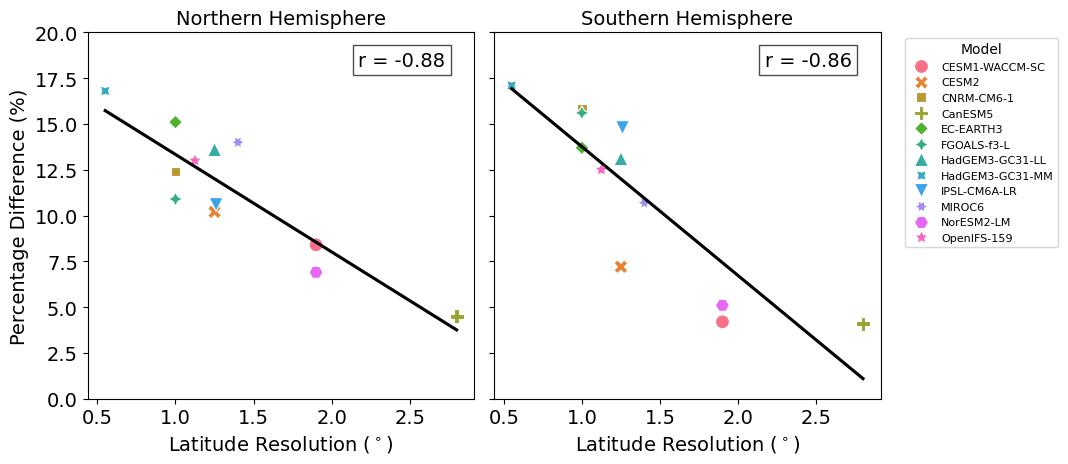

In [9]:
plot_pct_diff_vs_resolution(df)
